In [1]:
# Import all kinds of lambeq stuff 
from lambeq.backend.grammar import (Box, Cap, Cup, Diagram, Diagrammable,
                                    Functor, grammar, Id, Spider, Swap,
                                    Ty, Word)
from lambeq.backend.drawing import draw
import matplotlib.pyplot as plt
import matplotlib
from lambeq import AtomicType

# optimising the diagram to make the resulting quanutm circuit less complex
from lambeq import RemoveSwapsRewriter, RemoveCupsRewriter
from lambeq import Rewriter 

# creating the quantum circuit
from lambeq import IQPAnsatz
from pytket.extensions.qiskit import tk_to_qiskit

import numpy as np

# amplitude Encoding
from qiskit import QuantumCircuit

/home/bob/anaconda3/envs/code/lib/python3.9/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
import numpy as np

BATCH_SIZE = 10
EPOCHS = 300
SEED = 2
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('../datasets/mc_train_data.txt')
test_labels, test_data = read_data('../datasets/mc_test_data.txt')
val_labels, val_data = read_data('../datasets/mc_dev_data.txt')


# here, we can choose between either the original dataset by Coecke et al. or the new one for Gijs' data

gijs = True

if not gijs: 
    # new way, maybe the things after the words confused lambeq in creating the diagrams 
    with open('../datasets/newTestSentences.txt', 'r') as file: 
        test_data = file.readlines()
    with open('../datasets/newTrainSentences.txt', 'r') as file: 
        train_data = file.readlines()
    with open('../datasets/newValSentences.txt', 'r') as file: 
        val_data = file.readlines()

    test_data = [sentence.strip() for sentence in test_data]
    train_data = [sentence.strip() for sentence in train_data]
    val_data = [sentence.strip() for sentence in val_data]


if gijs:
    # new way, maybe the things after the words confused lambeq in creating the diagrams 
    with open('../datasets/testGijs.txt', 'r') as file: 
        test_data = file.readlines()
    with open('../datasets/trainGijs.txt', 'r') as file: 
        train_data = file.readlines()
    with open('../datasets/valGijs.txt', 'r') as file: 
        val_data = file.readlines()

    test_data = [sentence.strip() for sentence in test_data]
    train_data = [sentence.strip() for sentence in train_data]
    val_data = [sentence.strip() for sentence in val_data]

from lambeq import BobcatParser

parser = BobcatParser(verbose='text')

raw_train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True)
raw_test_diagrams = parser.sentences2diagrams(test_data, suppress_exceptions=True)
raw_val_diagrams = parser.sentences2diagrams(val_data, suppress_exceptions=True)


Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


In [3]:
# normalising 

from lambeq import RemoveCupsRewriter

remove_cups = RemoveCupsRewriter()

train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_val_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]

In [4]:

'''
In this file, we capture the rewritten ansatz to amplitude encode nouns in a circuit. 
'''

from __future__ import annotations

# __all__ = ['CircuitAnsatz',
#            'IQPAnsatz',
#            'Sim14Ansatz',
#            'Sim15Ansatz',
#            'StronglyEntanglingAnsatz']

from abc import abstractmethod
from collections.abc import Callable, Mapping
from itertools import cycle
from typing import Type

import numpy as np
from sympy import Symbol, symbols

from lambeq.ansatz import BaseAnsatz
from lambeq.backend.grammar import Box, Diagram, Functor, Ty
from lambeq.backend.quantum import (
    Bra,
    CRz,
    Diagram as Circuit,
    Discard,
    H,
    Id,
    Ket,
    quantum,
    qubit,
    Rotation,
    Rx, Ry, Rz, 
    CRy, 
    X
)

from lambeq import CircuitAnsatz

computational_basis = Id(qubit)

from lambeq import AtomicType

from lambeq import BobcatParser

N = AtomicType.NOUN
S = AtomicType.SENTENCE
adj = N @ N.l

parser = BobcatParser(verbose='text')

In [12]:
'''
Insert new Ansatz code here 
'''



'''
General Ansatz class that we changed for our purpose
'''

class CircuitAnsatz(BaseAnsatz):
    """Base class for circuit ansatz."""

    def __init__(self,
                 ob_map: Mapping[Ty, int],
                 n_layers: int,
                 n_single_qubit_params: int,
                 circuit: Callable[[int, np.ndarray], Circuit],
                 nounParams: np.ndarray, 
                 parameterDict: dict, 
                 discard: bool = False,
                 single_qubit_rotations: list[Type[Rotation]] | None = None,
                 postselection_basis: Circuit = computational_basis) -> None:
        """Instantiate a circuit ansatz.

        Parameters
        ----------
        ob_map : dict
            A mapping from :py:class:`lambeq.backend.grammar.Ty` to
            the number of qubits it uses in a circuit.
        n_layers : int
            The number of layers used by the ansatz.
        n_single_qubit_params : int
            The number of single qubit rotations used by the ansatz.
        circuit : callable
            Circuit generator used by the ansatz. This is a function
            (or a class constructor) that takes a number of qubits and
            a numpy array of parameters, and returns the ansatz of that
            size, with parameterised boxes.
        discard : bool, default: False
            Discard open wires instead of post-selecting.
        postselection_basis: Circuit, default: Id(qubit)
            Basis to post-select in, by default the computational basis.
        single_qubit_rotations: list of Circuit, optional
            The rotations to be used for a single qubit. When only a
            single qubit is present, the ansatz defaults to applying a
            series of rotations in a cycle, determined by this parameter
            and `n_single_qubit_params`.

        """
        self.ob_map = {src: qubit ** ty if isinstance(ty, int) else ty
                       for src, ty in ob_map.items()}
        self.n_layers = n_layers
        self.n_single_qubit_params = n_single_qubit_params
        self.circuit = circuit
        self.nounParams = nounParams
        self.parameterDict = parameterDict
        if len(nounParams) != n_single_qubit_params: 
            print('The number of noun parameters does not fit the number of single qubit operators. ')
        self.discard = discard
        self.postselection_basis = postselection_basis
        self.single_qubit_rotations = single_qubit_rotations or []

        self.functor = Functor(target_category=quantum,
                               ob=self._ob,
                               ar=self._ar)


    def __call__(self, diagram: Diagram) -> Circuit:
        """Convert a lambeq diagram into a lambeq circuit."""
        return self.functor(diagram)  # type: ignore[return-value]


    def ob_size(self, pg_type: Ty) -> int:
        """Calculate the number of qubits used for a given type."""
        return sum(map(len, map(self.functor, pg_type)))


    @abstractmethod
    def params_shape(self, n_qubits: int) -> tuple[int, ...]:
        """Calculate the shape of the parameters required."""


    def _ob(self, _: Functor, ty: Ty) -> Ty:
        return self.ob_map[ty]

    def _ar(self, _: Functor, box: Box) -> Circuit:
        label = self._summarise_box(box)
        dom, cod = self.ob_size(box.dom), self.ob_size(box.cod)

        n_qubits = max(dom, cod)
        if n_qubits == 0:
            circuit = Id()

        # NOUNS AND OTHER OPERATIONS THAT ACT ON ONE QUBIT ONLY
        elif n_qubits == 1:

            syms = symbols(f'{label}_0:{self.n_single_qubit_params}',
                           cls=Symbol)

            circuit = Id(qubit)
            # for rot, sym in zip(cycle(self.single_qubit_rotations), syms):
            #     print('rot', rot)
            #     circuit >>= rot(self.nounParams[0])

            # cycle ensures that we use all three parameters that we are given, because there is only two parameters specified! Rx and Rz, but we want Rx Rz Rx. 
            # for rot, nounParam in zip(cycle(self.single_qubit_rotations), self.nounParams): 
            #     circuit >>= rot(nounParam)

            circuit >>= Ry(self.nounParams[0])

            # remove first element from list! 
            print('REMOVEREMOVE JKJAJDFJ')
            self.nounParams = self.nounParams[1:]

        else:
            params_shape = self.params_shape(n_qubits)

            # Verbs and other non-nouns

            syms = symbols(f'{label}_0:{np.prod(params_shape)}', cls=Symbol)

            # indicesToDelete = []
            # symsToChange = []
            # 
            # for sym_no in range(len(syms)):
            #     sym = syms[sym_no]
            #     print(sym)
            #     if '_n_' in str(sym): 
            #         # indicesToDelete.append(sym_no)
            #         symsToChange.append(sym) 
            # 
            # syms = [syms[i] for i in range(len(syms)) if i not in indicesToDelete]

            
            params: np.ndarray = np.array(syms).reshape(params_shape)
            circuit = self.circuit(n_qubits, params)

        if cod > dom:
            circuit = Id(dom) @ Ket(*[0]*(cod - dom)) >> circuit
        elif cod < dom:
            if self.discard:
                circuit >>= Id(cod) @ Id().tensor(
                    *[Discard() for _ in range(dom - cod)]
                )
            else:
                circuit >>= Id(cod).tensor(
                    *[self.postselection_basis] * (dom-cod))
                circuit >>= Id(cod) @ Bra(*[0]*(dom - cod))
        return circuit
    


'''
This is a child of CircuitAnsatz, executing the amplitude encoding
'''

class IQPAmplitudeEncode(CircuitAnsatz):
    """Instantaneous Quantum Polynomial ansatz.

    An IQP ansatz interleaves layers of Hadamard gates with diagonal
    unitaries. This class uses :py:obj:`n_layers-1` adjacent CRz gates
    to implement each diagonal unitary.

    Code adapted from DisCoPy.

    """

    def __init__(self,
                 ob_map: Mapping[Ty, int],
                 n_layers: int,
                 nounParams: np.ndarray,
                 parameterDict: dict, 
                 n_single_qubit_params: int = 3,
                 discard: bool = False) -> None:
        """Instantiate an IQP ansatz.

        Parameters
        ----------
        ob_map : dict
            A mapping from :py:class:`lambeq.backend.grammar.Ty` to
            the number of qubits it uses in a circuit.
        n_layers : int
            The number of layers used by the ansatz.
        n_single_qubit_params : int, default: 3
            The number of single qubit rotations used by the ansatz.
        discard : bool, default: False
            Discard open wires instead of post-selecting.

        """
        super().__init__(ob_map,
                         n_layers,
                         n_single_qubit_params,
                         self.circuit,
                         nounParams, 
                         parameterDict, 
                         discard,
                         [Rx, Rz])


    def params_shape(self, n_qubits: int) -> tuple[int, ...]:
        return (self.n_layers, n_qubits - 1)


    def circuit(self, n_qubits: int, params: np.ndarray) -> Circuit:

        # when we amplitude encode the nouns, we don't want to draw the final Hadamard layer 
        addH = True
        
        if n_qubits == 1:
            # circuit = Rx(params[0]) >> Rz(params[1]) >> Rx(params[2])
            print('test')
        else:
            circuit = Id(n_qubits)
            hadamards = Id().tensor(*(n_qubits * [H]))
            print('params in circuitfunction:', params)
            for thetas in params:

                # print('first draw of circuit: ')
                # circuit.draw()
                print('thetas: ', thetas)
                if '_n_' in str(thetas[0]): 
                    print('we have to do somehting')
                    # continue 
                    circuit = noun_ansatz(str(thetas[0]), self.parameterDict, circuitt=circuit)

                    # remove the used noun parameters 
                    # self.nounParams = self.nounParams[4:]

                    addH = False
                    continue
                rotations = Id(n_qubits).then(*(
                    Id(i) @ CRz(thetas[i]) @ Id(n_qubits - 2 - i)
                    for i in range(n_qubits - 1)))
                circuit >>= hadamards >> rotations
                # print('after hadamard and rotations: ')
                # circuit.draw()

            if self.n_layers > 0 and addH == True:  # Final layer of Hadamards
                circuit >>= hadamards

        return circuit  # type: ignore[return-value]



def noun_ansatz(paramString: str, parameterDict, circuitt):
    '''
    this function returns a 2-qubit circuit encoding the four dimensional vector arr 
    '''
    word, dagger = GetWordFromParam(paramString)
    print('the word is:  ', word)
    print('is it daggered? ', dagger)

    arr = parameterDict[word]

    print('and the parameters are: ', arr)

    if len(arr) != 4: 
        print('Error, we need a four dimensional vector')
    
    # normalize vector 
    arr = arr / np.linalg.norm(arr)

    print('vector to amplitude encode: ', arr)

    a1 = np.linalg.norm(arr[0:2])
    a2 = np.linalg.norm(arr[2:])
    phi1 = np.arccos(a1)/np.pi

    # fix issues with rotations
    rot1 = arr[0:2]/a1
    phi2_cos = np.arccos(rot1[0])/np.pi
    phi2_sin = np.arcsin(rot1[1])/np.pi
    if not np.sign(phi2_cos) == np.sign(phi2_sin):
        phi2_cos *= -1
    rot2 = arr[2: ]/a2
    phi3_cos = np.arccos(rot2[0])/np.pi
    phi3_sin = np.arcsin(rot2[1])/np.pi
    if not np.sign(phi3_cos) == np.sign(phi3_sin):
        phi3_cos *= -1

    # print('is this executed succesfully?? The parameters are: ', phi1)

    partToAdd = Ry(phi1) @ Id(1) >> CRy(phi3_cos) >> X @ Id(1) >> CRy(phi2_cos) >> X @ Id(1)

    # if the word is upside down, we flip the whole circuit 
    if dagger:
        circuitt >>= partToAdd.dagger()

    # if the word is not upside down, we just append the circuit as is 
    else: 
        circuitt >>= partToAdd

    # making sure the amplitude encoding works as intended 

    # circuit.draw()
    # amplitude = circuit.eval()
    # print('the amplitude is: ', amplitude)
    # probability = abs(amplitude) ** 2   

    # print('the probability is: ', probability)

    # return circuit >> Ry(phi1) @ circuit.id(1) >> CRy(phi3_cos) >> X @ circuit.id(1) >> CRy(phi2_cos) >> X @ circuit.id(1)
    return circuitt

def GetWordFromParam(param: str):
    word = param.split('_')[0] 

    if '†' in word: 
        dagger = True 
        word = word.replace('†', '')
    else: 
        dagger = False 
    
    return word, dagger






In [13]:
'''
Load the word dict  
'''
import json

with open("../datasets/newNounVectorsPCA.json", 'r') as fp:
    parameterDict = json.load(fp)



The number of noun parameters does not fit the number of single qubit operators. 
params in circuitfunction: [[chef__n_0]]
thetas:  [chef__n_0]
we have to do somehting
the word is:   chef
is it daggered?  False
and the parameters are:  [0.48585536304548504, 0.11974828010428734, 0.25764646682613696, 0.8265731750692211]
vector to amplitude encode:  [0.48585536 0.11974828 0.25764647 0.82657318]
params in circuitfunction: [[prepares__n.r@s@n.l_0 prepares__n.r@s@n.l_1 prepares__n.r@s@n.l_2
  prepares__n.r@s@n.l_3]]
thetas:  [prepares__n.r@s@n.l_0 prepares__n.r@s@n.l_1 prepares__n.r@s@n.l_2
 prepares__n.r@s@n.l_3]
params in circuitfunction: [[sauce†_n__0]]
thetas:  [sauce†_n__0]
we have to do somehting
the word is:   sauce
is it daggered?  True
and the parameters are:  [0.7496800847924783, -0.46494124025783223, 0.41714562135555744, -0.218629696420539]
vector to amplitude encode:  [ 0.74968008 -0.46494124  0.41714562 -0.2186297 ]
params in circuitfunction: [[skillful†_n@n.l__0 skillful†_n@n.l

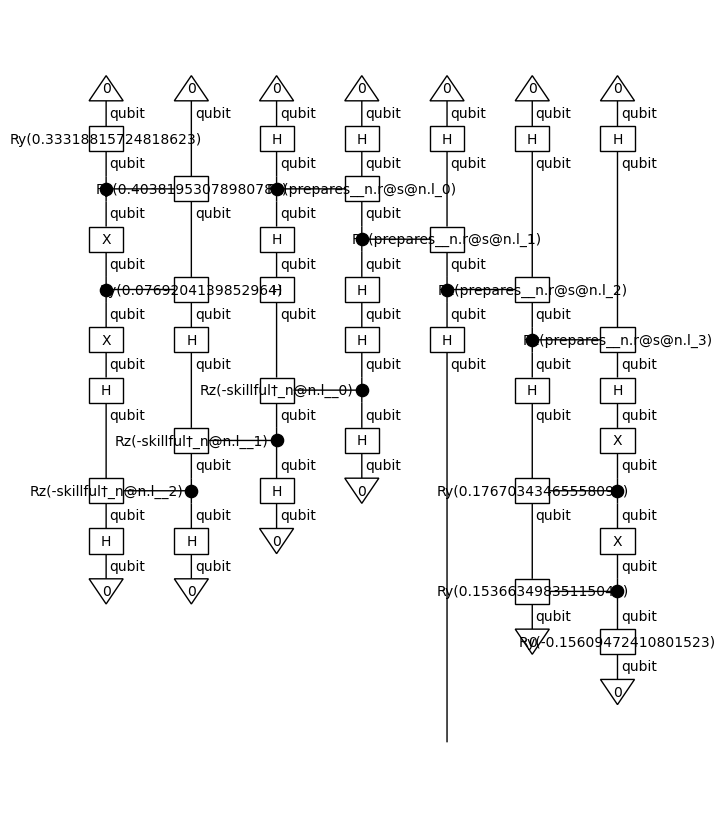

In [16]:
# create quantum circuits

from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 2, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)


from IQPAmplitudeEncode import * 


ansatz = IQPAmplitudeEncode2QB({AtomicType.NOUN: 2, AtomicType.SENTENCE: 1},
                   n_layers=1, nounParams=np.array([1,2,3,4, 1,2,3,4,]), parameterDict=parameterDict, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
# val_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
# test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw(figsize=(6, 8))

In [15]:
print(parameterDict)

[0.48585536304548504, 0.11974828010428734, 0.25764646682613696, 0.8265731750692211]

{'man': [-0.04641067895770814, 0.919485873505192, 0.32529162382451915, -0.2158173690245671], 'woman': [-0.06855026708725188, 0.9709632125988493, 0.16586735071920453, -0.1581749747190777], 'person': [-0.409554780069224, 0.7858679411358752, 0.15043141698729245, -0.4382315027476978], 'dinner': [0.7157790849154739, 0.09770874100670372, -0.6914105758445561, 0.008044820616453086], 'meal': [0.796322089300245, -0.20939483198928302, -0.5547830975384541, -0.11933419088555804], 'sauce': [0.7496800847924783, -0.46494124025783223, 0.41714562135555744, -0.218629696420539], 'program': [-0.5036655288610968, -0.1017226527472674, -0.7569494243772386, 0.4037339543438199], 'application': [-0.7212593629102749, -0.5291040032507465, -0.2892821106702728, -0.3408074905345396], 'software': [-0.7855718102171613, -0.6135386856255265, 0.04323500836953742, -0.06766052234737652], 'chef': [0.48585536304548504, 0.11974828010428734, 0.25764646682613696, 0.8265731750692211], 'programmer': [-0.7705414858591404, -0.280758